<a href="https://www.kaggle.com/code/jeppez/houses-prediction-30-off?scriptVersionId=99143056" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



pd.options.display.max_rows = 1000
pd.options.display.max_columns = 20



train = pd.read_csv('../input/datasethuis/Data555.csv', sep=';', encoding='latin-1')
test = pd.read_csv('../input/datasethuis/Data555.csv', sep=';', encoding='latin-1')

for name in train.head():
  zonderspaties = name.replace(" ", "_")
  train = train.rename(columns={name: zonderspaties})

In [2]:
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

<AxesSubplot:title={'center':'Log Normal'}, xlabel='Vraagprijs'>

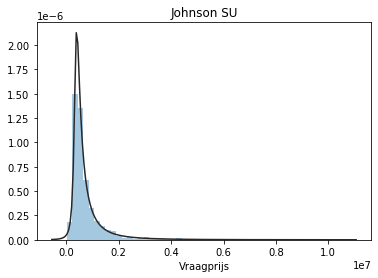

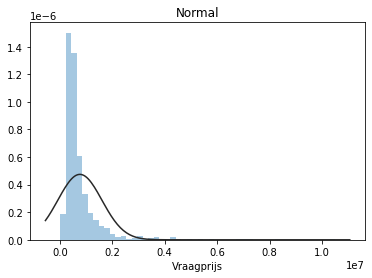

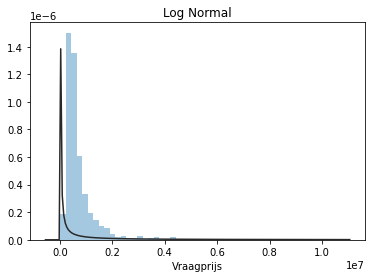

In [3]:
import scipy.stats as st
y = train['Vraagprijs']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=st.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=st.lognorm)

In [4]:
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(train[quantitative])
normal = normal.apply(test_normality)
print(not normal.any())

False


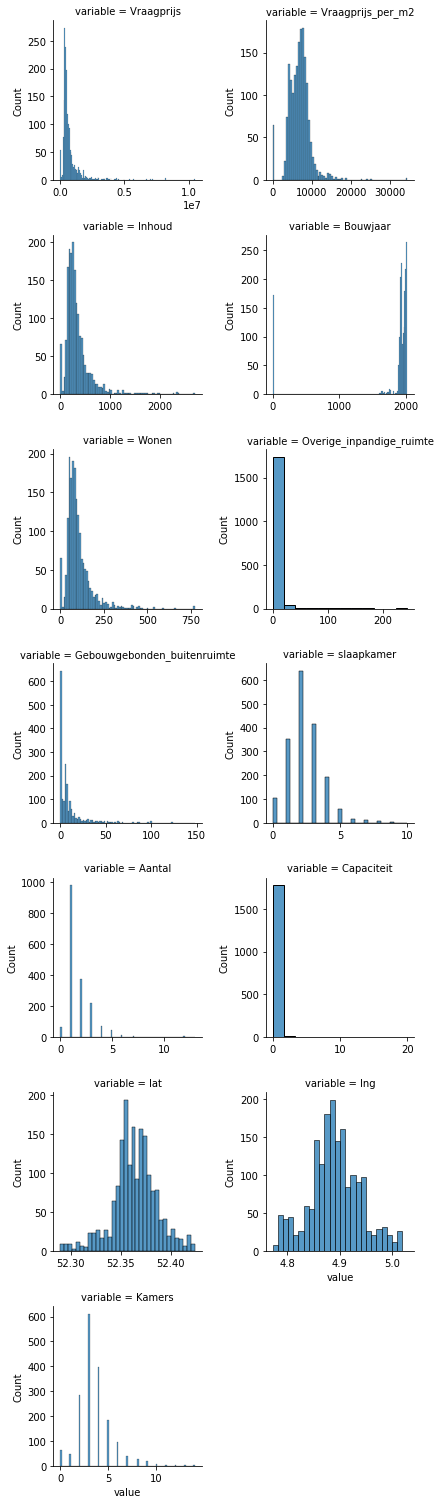

In [5]:
f = pd.melt(train, value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.histplot, "value")

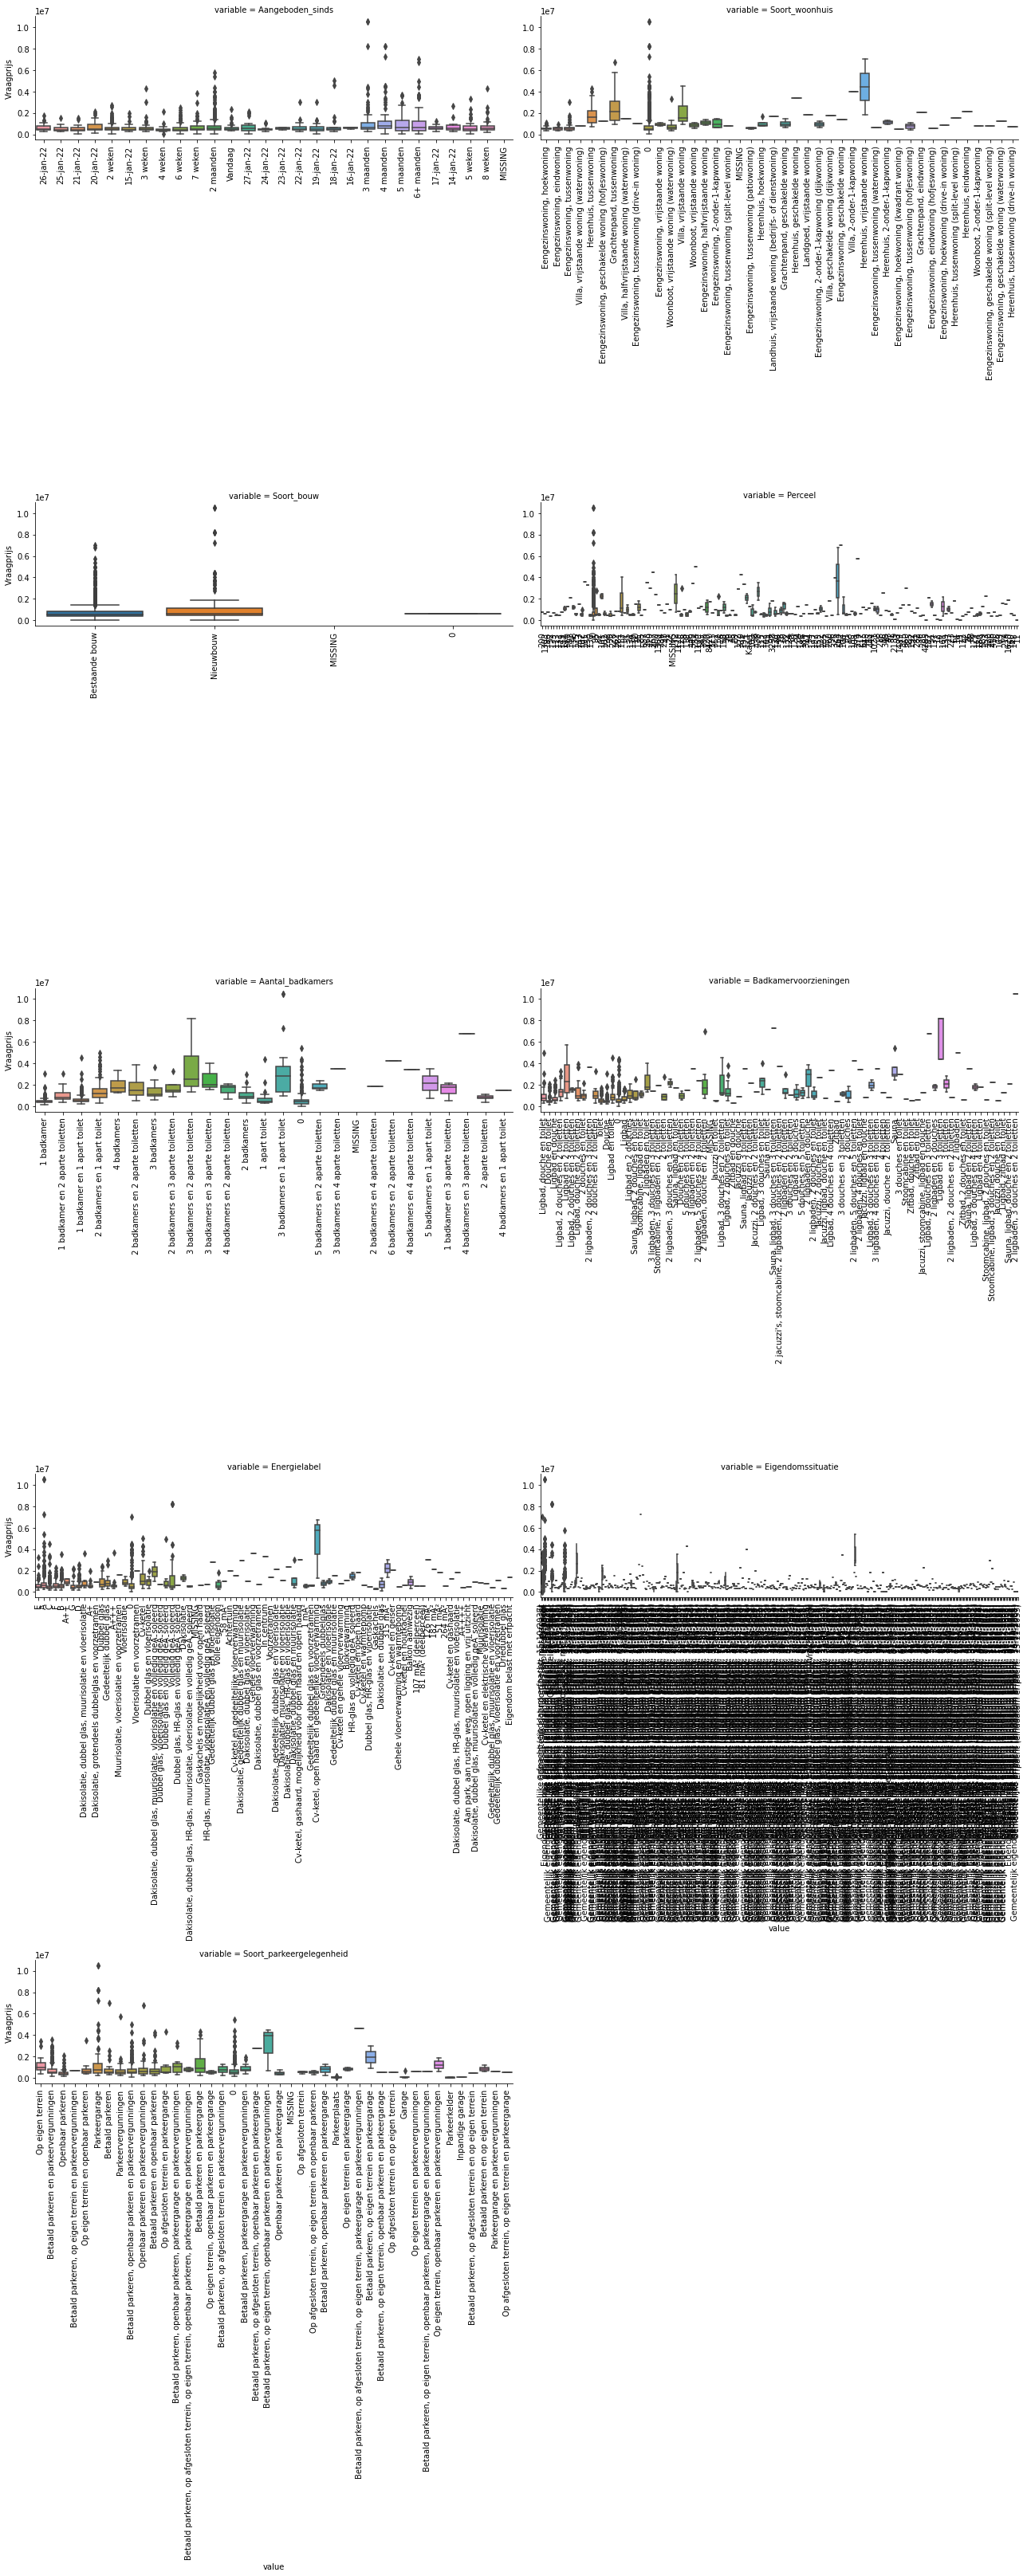

In [6]:
for c in qualitative:
    train[c] = train[c].astype('category')
    if train[c].isnull().any():
        train[c] = train[c].cat.add_categories(['MISSING'])
        train[c] = train[c].fillna('MISSING')

def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
f = pd.melt(train, id_vars=['Vraagprijs'], value_vars=qualitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, height=9)
g = g.map(boxplot, "value", "Vraagprijs")

In [7]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'Vraagprijs']].groupby(feature).mean()['Vraagprijs']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o
    
qual_encoded = []
for q in qualitative:  
    encode(train, q)
    qual_encoded.append(q+'_E')

    print(qual_encoded)

['Aangeboden_sinds_E']
['Aangeboden_sinds_E', 'Soort_woonhuis_E']
['Aangeboden_sinds_E', 'Soort_woonhuis_E', 'Soort_bouw_E']
['Aangeboden_sinds_E', 'Soort_woonhuis_E', 'Soort_bouw_E', 'Perceel_E']
['Aangeboden_sinds_E', 'Soort_woonhuis_E', 'Soort_bouw_E', 'Perceel_E', 'Aantal_badkamers_E']
['Aangeboden_sinds_E', 'Soort_woonhuis_E', 'Soort_bouw_E', 'Perceel_E', 'Aantal_badkamers_E', 'Badkamervoorzieningen_E']
['Aangeboden_sinds_E', 'Soort_woonhuis_E', 'Soort_bouw_E', 'Perceel_E', 'Aantal_badkamers_E', 'Badkamervoorzieningen_E', 'Energielabel_E']
['Aangeboden_sinds_E', 'Soort_woonhuis_E', 'Soort_bouw_E', 'Perceel_E', 'Aantal_badkamers_E', 'Badkamervoorzieningen_E', 'Energielabel_E', 'Eigendomssituatie_E']
['Aangeboden_sinds_E', 'Soort_woonhuis_E', 'Soort_bouw_E', 'Perceel_E', 'Aantal_badkamers_E', 'Badkamervoorzieningen_E', 'Energielabel_E', 'Eigendomssituatie_E', 'Soort_parkeergelegenheid_E']


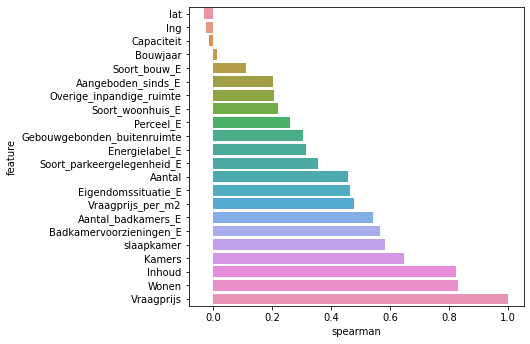

In [8]:
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['Vraagprijs'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
features = quantitative + qual_encoded
spearman(train, features)

<AxesSubplot:>

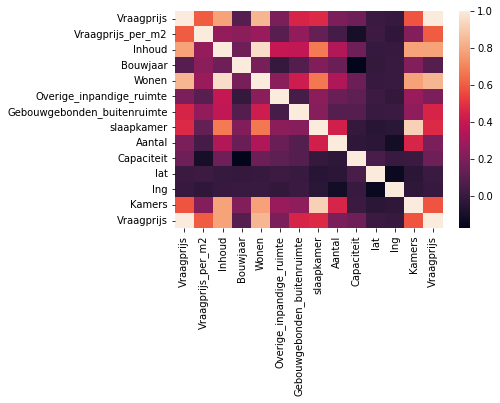

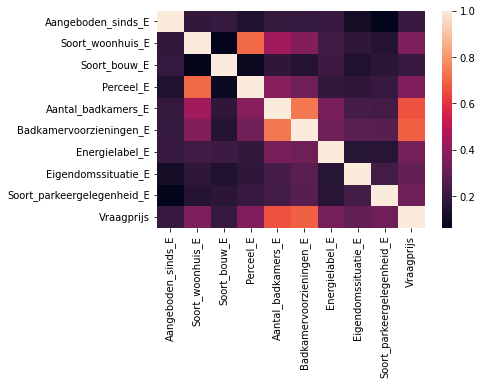

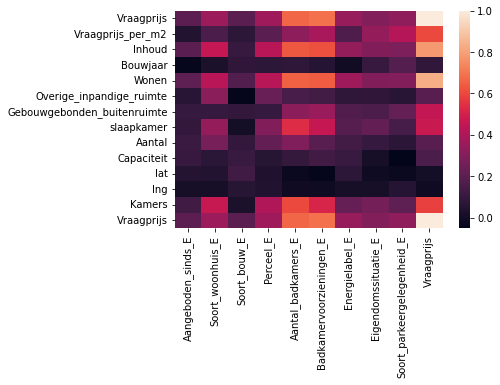

In [9]:
plt.figure(1)
corr = train[quantitative+['Vraagprijs']].corr()
sns.heatmap(corr)
plt.figure(2)
corr = train[qual_encoded+['Vraagprijs']].corr()
sns.heatmap(corr)
plt.figure(3)
corr = pd.DataFrame(np.zeros([len(quantitative)+1, len(qual_encoded)+1]), index=quantitative+['Vraagprijs'], columns=qual_encoded+['Vraagprijs'])
for q1 in quantitative+['Vraagprijs']:
    for q2 in qual_encoded+['Vraagprijs']:
        corr.loc[q1, q2] = train[q1].corr(train[q2])
sns.heatmap(corr)

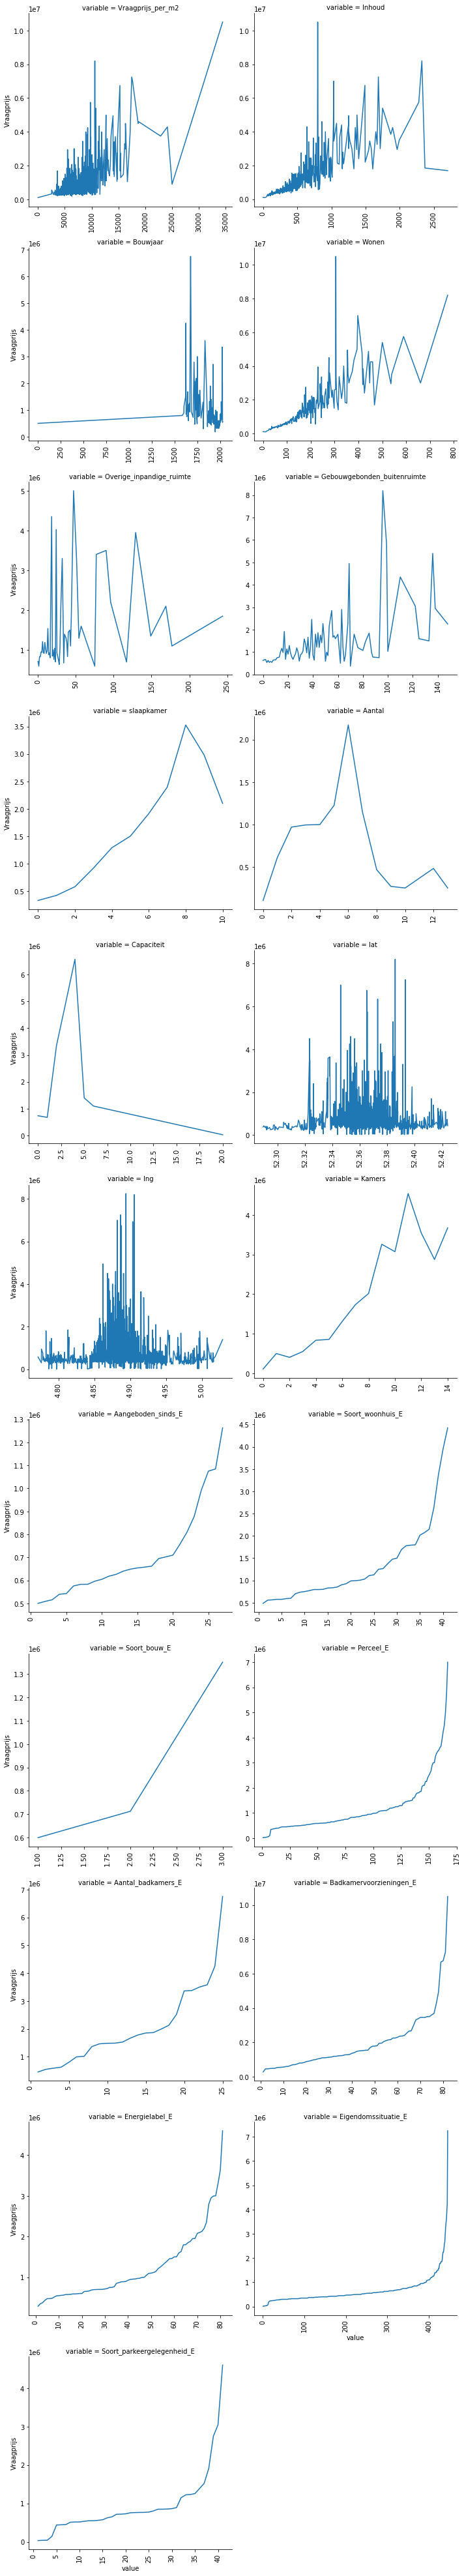

In [10]:
def pairplot(x, y, **kwargs):
    ax = plt.gca()
    ts = pd.DataFrame({'time': x, 'val': y})
    ts = ts.groupby('time').mean()
    ts.plot(ax=ax)
    plt.xticks(rotation=90)
    
f = pd.melt(train, id_vars=['Vraagprijs'], value_vars=quantitative+qual_encoded)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, height=5)
g = g.map(pairplot, "value", "Vraagprijs")

In [11]:
import patsy

def error(actual, predicted):
    actual = np.log(actual)
    predicted = np.log(predicted)
    return np.sqrt(np.sum(np.square(actual-predicted))/len(actual))

Y, X = patsy.dmatrices(
    "Vraagprijs ~ \
        Aangeboden_sinds_E + \
        Soort_woonhuis_E + \
        Soort_bouw_E + \
        Aantal_badkamers_E + \
        Badkamervoorzieningen_E + \
        Energielabel_E + \
        Overige_inpandige_ruimte + \
        Gebouwgebonden_buitenruimte + \
        Energielabel_E + \
        Eigendomssituatie_E + \
        Soort_parkeergelegenheid_E + \
        Vraagprijs_per_m2 + \
        Bouwjaar + \
        Inhoud + \
        slaapkamer + \
        Aantal + \
        Capaciteit + \
        lat + \
        lng + \
        Kamers + \
        Perceel_E",
    train.to_dict('list'))

ridge = linear_model.RidgeCV(cv=10)
ridge.fit(X, np.log(Y))
Ypred = np.exp(ridge.predict(X))
print(error(Y,Ypred))



0.30432812266786374


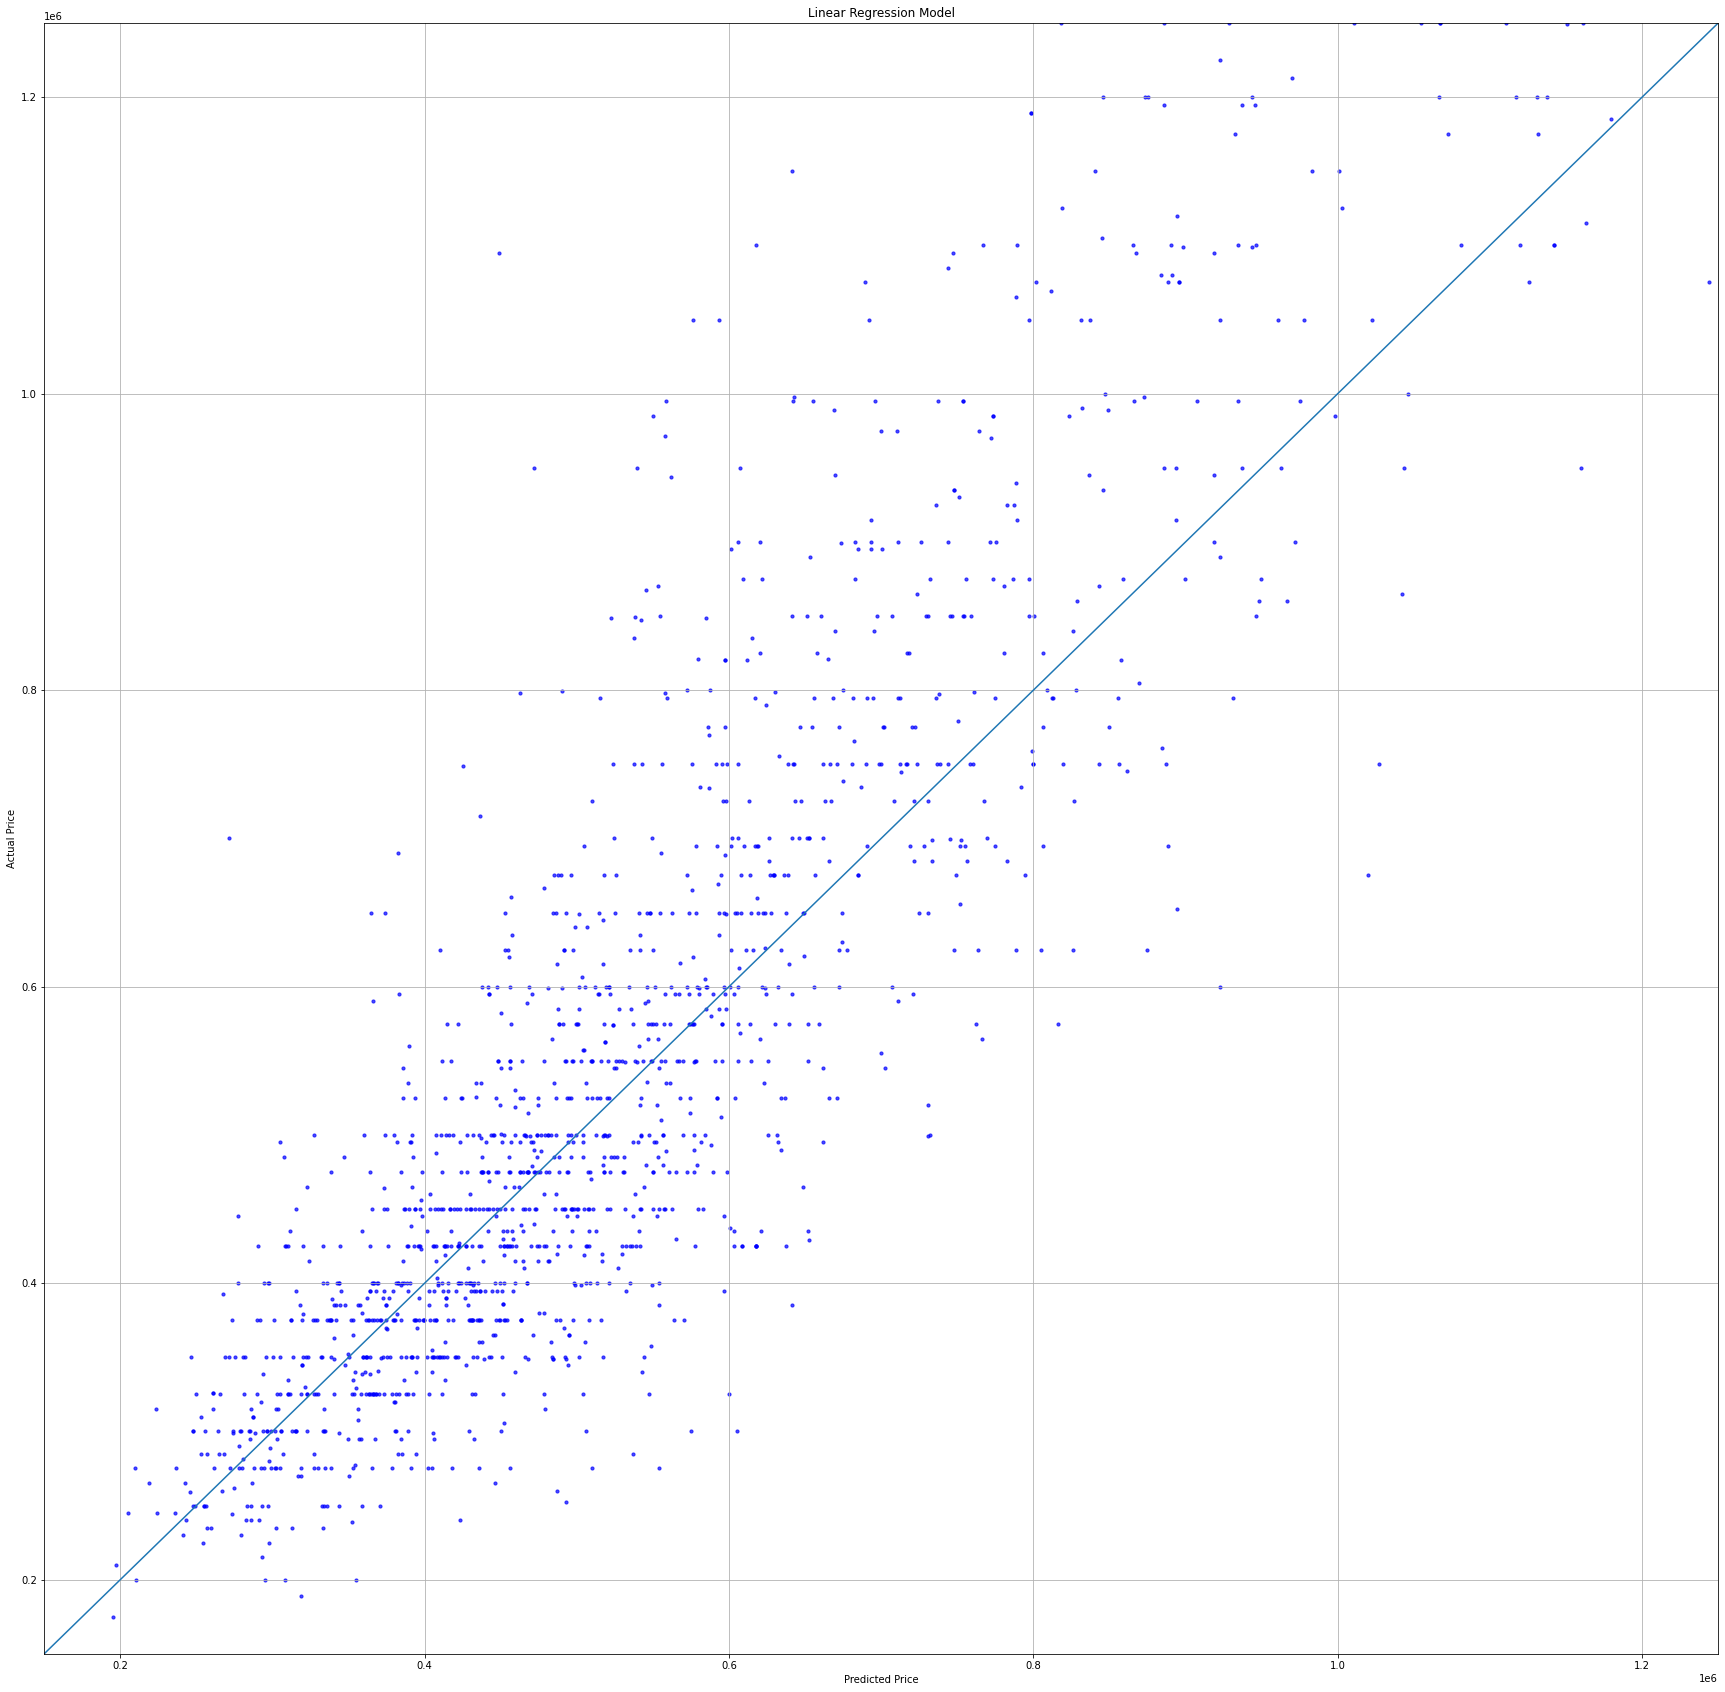

In [12]:
plt.figure(figsize=(30, 30))
plt.scatter(Ypred, Y, alpha=.7,
            color='b', s=10)
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')
plt.grid()
plt.axis([150000, 1250000, 150000, 1250000])
plt.plot([150000, 1250000], [150000, 1250000])
plt.show()

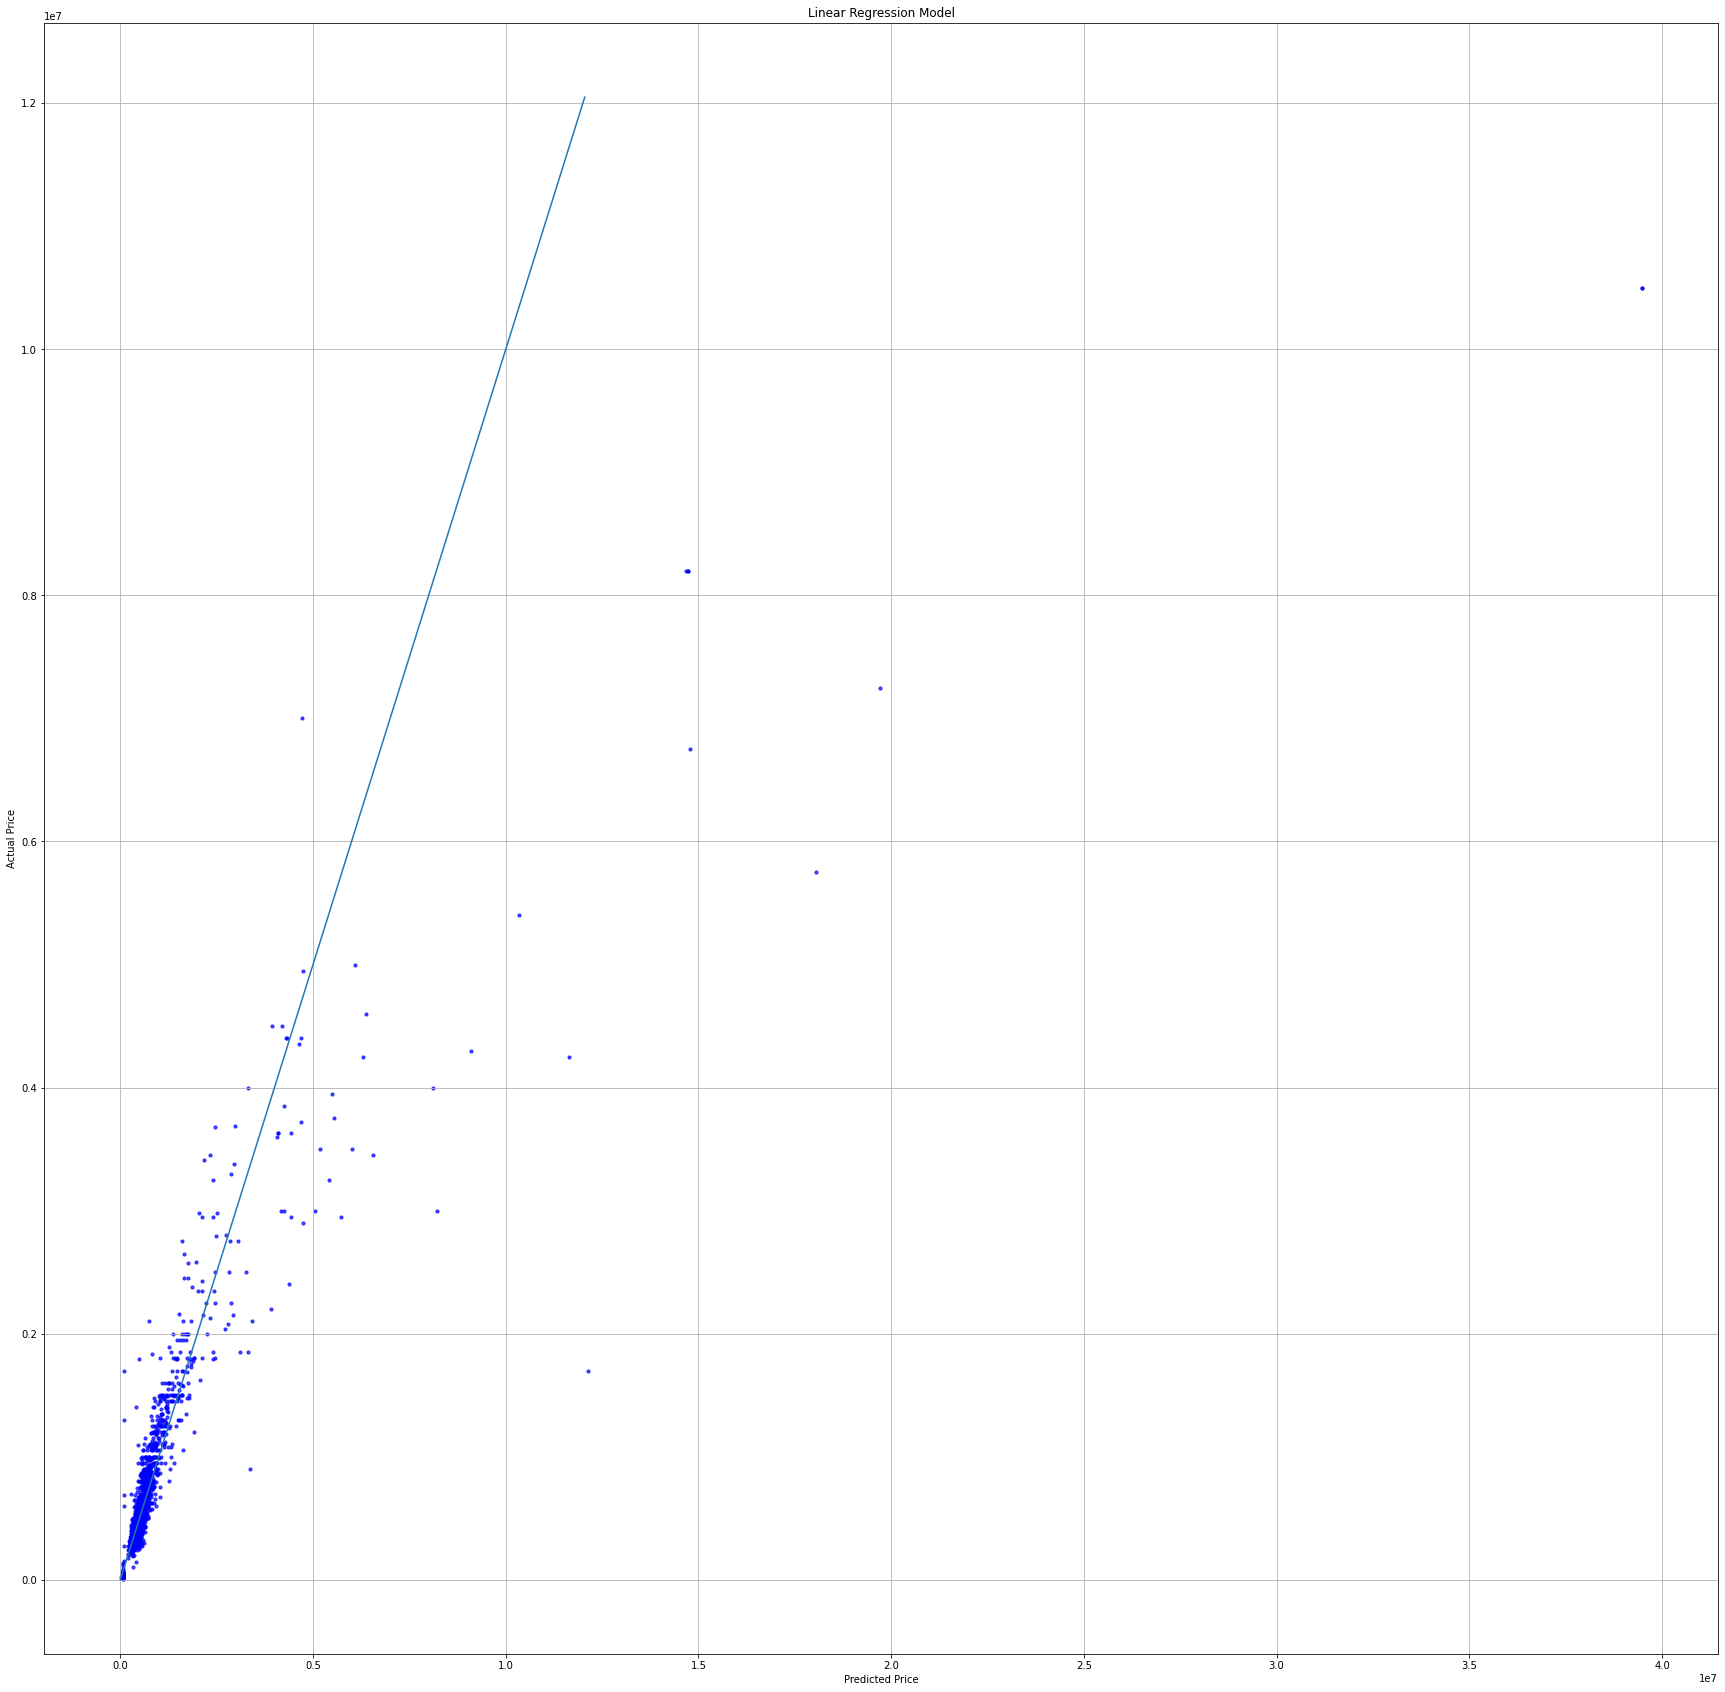

In [13]:
plt.figure(figsize=(30, 30))
plt.scatter(Ypred, Y, alpha=.7,
            color='b', s=10)
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')
plt.grid()
plt.plot([0, 12050000], [0, 12050000])
plt.show()